In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import random

from IPython import display
from skimage.draw import random_shapes, rectangle, polygon, circle

tf.config.gpu.set_per_process_memory_growth(enabled=True)

In [2]:
SHAPE_SIZE = 28
IMAGE_COUNT = 600
BATCH_SIZE = 32

In [3]:
def generate_image_mask(size=(448, 448), max_shapes=3, show_result=False):
    image, labels = random_shapes(size, min_shapes=1, max_shapes=max_shapes,
                             min_size=size[0]/4, allow_overlap=True, multichannel=False, shape='triangle')

    masks = []
    for i in range(0, len(labels)):
        img= np.zeros(size, dtype=np.uint8)

        if(labels[i][0] == 'rectangle'):
            rr, cc = rectangle((labels[i][1][0][0], labels[i][1][1][0]), (labels[i][1][0][1], labels[i][1][1][1]),
                       shape=img.shape)
        if(labels[i][0] == 'circle'):
            y = labels[i][1][0][1]- (labels[i][1][0][1] - labels[i][1][0][0]) / 2
            x = labels[i][1][1][1]-(labels[i][1][1][1] - labels[i][1][1][0]) / 2
            r = (labels[i][1][0][1] - labels[i][1][0][0]) / 2        
            rr, cc = circle(y, x, r, shape=img.shape)
        if(labels[i][0] == 'triangle'):
            x = (labels[i][1][1][0], labels[i][1][1][1] - (labels[i][1][1][1] - labels[i][1][1][0]) / 2, labels[i][1][1][1], labels[i][1][1][0])
            y = (labels[i][1][0][1], labels[i][1][0][0], labels[i][1][0][1], labels[i][1][0][1])
            rr, cc = polygon(y, x, shape=img.shape)                

        img[rr, cc] = 1
        masks.append(img)
        
    if(show_result):
        print(labels)
        fig=plt.figure(figsize=(8, 8))
        fig.add_subplot(1, len(labels)+1, 1)
        plt.imshow(image)
        for i in range(0, len(labels)):    
            fig.add_subplot(1, len(labels)+1, i+2)
            plt.imshow(masks[i], cmap="Greys")
        plt.show()
    return image, masks

In [4]:
def preprocess_image(raw_image):
    t = tf.convert_to_tensor(raw_image, np.float32)
    t = tf.reshape(t, (SHAPE_SIZE, SHAPE_SIZE, 1,))
    t = (t - 127.5) / 127.5
    return t

def preprocess_mask(raw_mask):
    t = tf.convert_to_tensor(raw_mask, np.float32)
    #t = tf.dense(t, (784))
    t = tf.reshape(t, (SHAPE_SIZE, SHAPE_SIZE, 1,))
    t = (t - 127.5) / 127.5
    return t

0
60
120
180
240
300
360
420
480
540


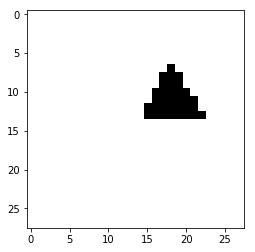

In [5]:
images = []
masks = []
for i in range(0, IMAGE_COUNT):
    image, img_masks = generate_image_mask(size=(SHAPE_SIZE, SHAPE_SIZE), max_shapes=1)
    images.append(preprocess_image(image))
    masks.append(preprocess_mask(img_masks[0]))
    if((i / IMAGE_COUNT * 100.0) % 10 == 0):
        print(i)
# Display a sample image
plt.imshow(images[0][:, :, 0] * 127.5 + 127.5, cmap='gray')
#plt.imshow(images[0][:, :] * 127.5 + 127.5, cmap='gray')

In [6]:
img_ds = tf.data.Dataset.from_tensor_slices(images)
msk_ds = tf.data.Dataset.from_tensor_slices(masks)
img_msk_ds = tf.data.Dataset.zip((img_ds, msk_ds))

In [7]:
# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
#ds = img_msk_ds.apply(
#  tf.data.experimental.shuffle_and_repeat(buffer_size=IMAGE_COUNT))
#ds = ds.batch(BATCH_SIZE)
#ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#ds

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = img_msk_ds.shuffle(buffer_size=IMAGE_COUNT)
#ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.float32, tf.float32)>

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(28,28,1,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Reshape((28, 28, 256)))
    #assert model.output_shape == (None, 28, 28, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 14, 14, 64)
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    
    #model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 28, 28, 32)
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    
    #model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 56, 56, 16)
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 56, 56, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    ########
    #model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 56, 56, 16)
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    
    #model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 112, 112, 8)
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 224, 224, 1)

    return model

(1, 28, 28, 1)


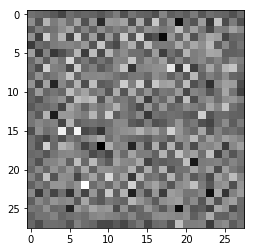

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, SHAPE_SIZE, SHAPE_SIZE, 1])
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[SHAPE_SIZE, SHAPE_SIZE, 1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))    
    
    #model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
    
    #model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))        
    
    #model.add(layers.Conv2D(2048, (5, 5), strides=(2, 2), padding='same'))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
    
    #model.add(layers.Conv2D(4096, (5, 5), strides=(2, 2), padding='same'))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [ ]:
discriminator = make_discriminator_model()
print(generated_image.shape)
decision = discriminator(generated_image)
print (decision)

(1, 28, 28, 1)
tf.Tensor([[-0.00011496]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 5
noise_dim = 28
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim, noise_dim, 1])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, masks):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim, noise_dim, 1])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(masks, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, mask_batch in dataset:
            train_step(image_batch, mask_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
%%time
train(ds, EPOCHS)

In [ ]:
anim_file = 'seg-shapes.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        #frame = 2*(i**0.5)
        #if round(frame) > round(last):
        #  last = frame
        #else:
        #  continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
#if IPython.version_info > (6,2,0,''):
display.Image(filename=anim_file)